In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
feature=pd.read_csv('feature.csv')
target=pd.read_csv('target.csv')

In [4]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_retweet_count       8328 non-null   int64  
 1   total_favorite_count      8328 non-null   int64  
 2   total_hashtag_count       8328 non-null   int64  
 3   total_url_count           8328 non-null   int64  
 4   total_mentions_count      8328 non-null   int64  
 5   total_media_count         8328 non-null   int64  
 6   number_of_tweets_scraped  8328 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 455.6 KB


In [5]:
targetSR=target['mbti_personality']

In [6]:
for row in target.index:
    # ie 구분
    if 'i' in target.loc[row,'mbti_personality']:
        target.loc[row,'ie']='i'
    else: target.loc[row,'ie']='e'

    # ns 구분
    if 'n' in target.loc[row,'mbti_personality']:
        target.loc[row,'ns']='n'
    else: target.loc[row,'ns']='s'

    # ft 구분
    if 'f' in target.loc[row,'mbti_personality']:
        target.loc[row,'ft']='f'
    else: target.loc[row,'ft']='t'

    # jp구분
    if 'j' in target.loc[row,'mbti_personality']:
        target.loc[row,'jp']='j'
    else: target.loc[row,'jp']='p'

In [7]:
#target.to_csv('target_2.csv',index=False)

## 데이터 확인

In [8]:
target_ie=target['ie']
target_ns=target['ns']
target_ft=target['ft']
target_jp=target['jp']

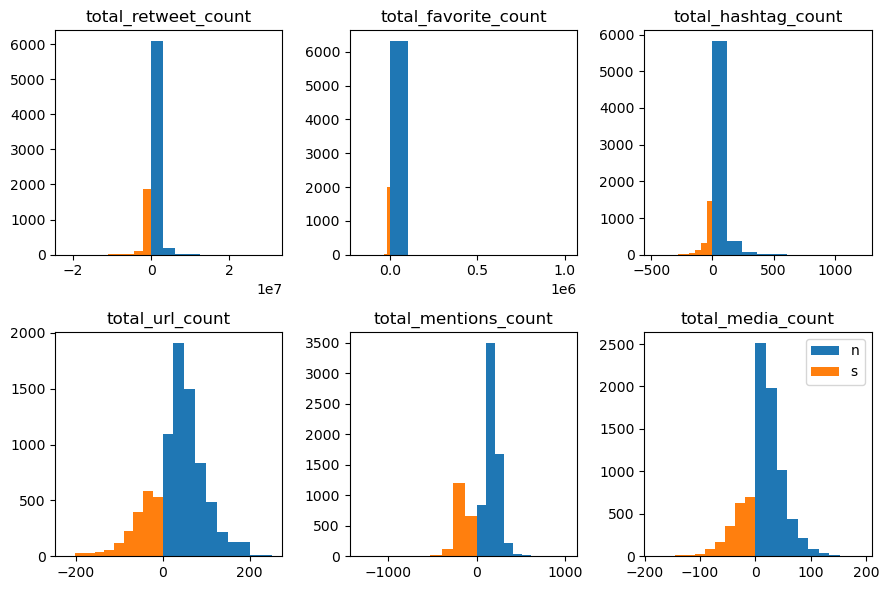

In [9]:
n_feature=feature[target_ns=='n']
s_feature=feature[target_ns=='s']
fig,ax=plt.subplots(figsize=(9,6),ncols=3,nrows=2)
for i in range(6):
    ax[i//3,i%3].hist(n_feature[feature.columns[i]],label='n')
    ax[i//3,i%3].hist(-s_feature[feature.columns[i]],label='s')
    ax[i//3,i%3].set(title=feature.columns[i])
plt.tight_layout()
plt.legend()

## 데이터셋 분리

In [10]:
target_ns.replace('n',0,inplace=True)
target_ns.replace('s',1,inplace=True)


In [11]:
from sklearn.model_selection import train_test_split, cross_validate

c:\Users\KDP-30\anaconda3\envs\TEXT_018_230_38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
X_train,X_test,y_train,y_test=train_test_split(feature,target_ns,stratify=targetSR,random_state=38)

In [13]:
y_train.value_counts()

ns
0    4739
1    1507
Name: count, dtype: int64

## 스케일링

In [14]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [15]:
minmax=MinMaxScaler()
standard=StandardScaler()

In [16]:
minmax.fit(X_train)
X_train_minmax=minmax.transform(X_train)
X_test_minmax=minmax.transform(X_test)

standard.fit(X_train)
X_train_standard=standard.transform(X_train)
X_test_standard=standard.transform(X_test)

## 학습

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
model=RandomForestClassifier(random_state=38)

In [19]:
model.fit(X_train,y_train)
print(f'train score : {model.score(X_train,y_train)}')
print(f'test score : {model.score(X_test,y_test)}')

train score : 0.999839897534422
test score : 0.7579250720461095


## 튜닝

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# RandomForestClassfier 하이퍼 파라미터 설정
params={'max_depth':range(10,20),'min_samples_leaf':range(10,15)}

searchCV=RandomizedSearchCV(model,
                            param_distributions=params,
                            verbose=4)

searchCV.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .max_depth=17, min_samples_leaf=10;, score=0.766 total time=   1.2s
[CV 2/5] END .max_depth=17, min_samples_leaf=10;, score=0.750 total time=   1.3s
[CV 3/5] END .max_depth=17, min_samples_leaf=10;, score=0.765 total time=   1.3s
[CV 4/5] END .max_depth=17, min_samples_leaf=10;, score=0.763 total time=   1.2s
[CV 5/5] END .max_depth=17, min_samples_leaf=10;, score=0.765 total time=   1.3s
[CV 1/5] END .max_depth=18, min_samples_leaf=13;, score=0.767 total time=   1.1s
[CV 2/5] END .max_depth=18, min_samples_leaf=13;, score=0.754 total time=   1.1s
[CV 3/5] END .max_depth=18, min_samples_leaf=13;, score=0.765 total time=   1.1s
[CV 4/5] END .max_depth=18, min_samples_leaf=13;, score=0.764 total time=   1.0s
[CV 5/5] END .max_depth=18, min_samples_leaf=13;, score=0.764 total time=   1.1s
[CV 1/5] END .max_depth=11, min_samples_leaf=14;, score=0.766 total time=   1.0s
[CV 2/5] END .max_depth=11, min_samples_leaf=14;

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=38),
                   param_distributions={'max_depth': range(10, 20),
                                        'min_samples_leaf': range(10, 15)},
                   verbose=4)

In [21]:
print(f'max depth {searchCV.best_estimator_.max_depth}')
print(f'min_samples_leaf {searchCV.best_estimator_.min_samples_leaf}')

max depth 18
min_samples_leaf 13


In [22]:
searchCV.best_estimator_.score(X_train,y_train)

0.7949087415946205

In [23]:
searchCV.best_estimator_.score(X_test,y_test)

0.7617675312199808

## 성능지표

In [24]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

pred=searchCV.best_estimator_.predict(X_test)
print(f'정확도 { accuracy_score(y_test,pred)} 정밀도 {precision_score(y_test,pred)} 재현율 {recall_score(y_test,pred)}')

정확도 0.7617675312199808 정밀도 0.5340909090909091 재현율 0.09362549800796813


In [25]:
print(confusion_matrix(y_test,pred))

[[1539   41]
 [ 455   47]]


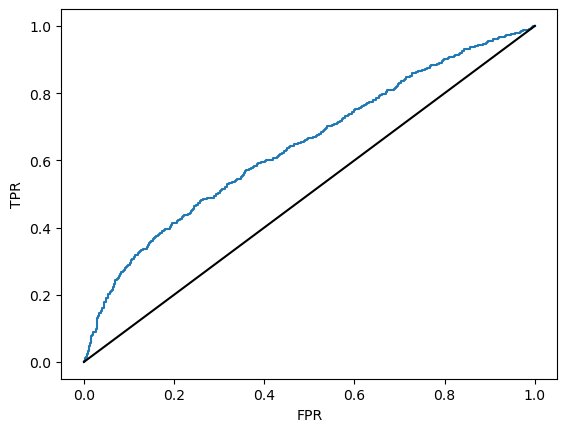

In [26]:
from sklearn.metrics import roc_curve
pred_proba=searchCV.best_estimator_.predict_proba(X_test)[:,1]

fprs,tprs,thresholds=roc_curve(y_test,pred_proba)
plt.plot(fprs,tprs,label='ROC')
plt.plot([0,1],[0,1],'k-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [1]:
searchCV.best_estimator_.feature_importances_

NameError: name 'searchCV' is not defined

In [27]:
import os
import torch
num='ns'
model=searchCV.best_estimator_
# 모델 폴더가 없다면 생성
if not os.path.exists('model/'):
    os.mkdir('model/')


    torch.save(model,f'model/best_model{num}.pth')